In [18]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import F1Score
from tqdm import tqdm

BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = 'brain_mri_dataset'

Loading pituitary: 100%|████████████████████████████████████████████████████████████| 667/667 [00:01<00:00, 385.08it/s]


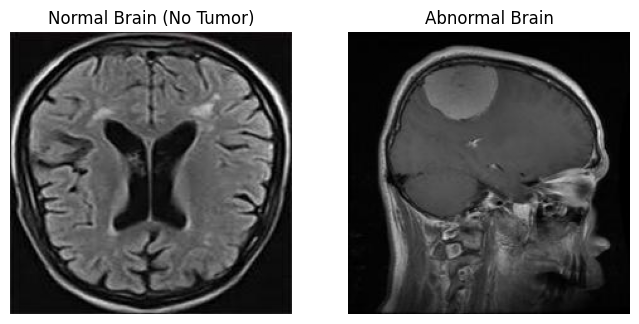

In [19]:
images = []
labels = []

normal_class = 'notumor'
abnormal_classes = [c for c in os.listdir(DATA_DIR) if c != normal_class]

# Load normal images
normal_images = []
for img_name in tqdm(os.listdir(os.path.join(DATA_DIR, normal_class)), desc=f'Loading {normal_class}'):
    if img_name.lower().endswith('.jpg'):
        img_path = os.path.join(DATA_DIR, normal_class, img_name)
        img = load_img(img_path, target_size=(224,224))
        img_array = img_to_array(img) / 255.0
        normal_images.append(img_array)

# Load abnormal images and undersample each class to 667
abnormal_images = []
for label in abnormal_classes:
    folder = os.path.join(DATA_DIR, label)

    img_names = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
    img_names = shuffle(img_names, random_state=42)[:667]

    for img_name in tqdm(img_names, desc=f'Loading {label}'):
        img_path = os.path.join(folder, img_name)
        img = load_img(img_path)
        img_array = img_to_array(img) / 255.0
        abnormal_images.append(img_array)

normal_img = random.choice(normal_images)
abnormal_img = random.choice(abnormal_images)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(normal_img)
plt.title("Normal Brain (No Tumor)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(abnormal_img)
plt.title("Abnormal Brain")
plt.axis("off")
plt.show()

In [20]:
# Combine normal and abnormal
images = np.array(normal_images + abnormal_images)
labels = np.array([0]*len(normal_images) + [1]*len(abnormal_images))  # 0=normal, 1=abnormal

# Shuffle dataset
images, labels = shuffle(images, labels, random_state=42)

# Split
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, test_size=0.1, stratify=labels, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

In [21]:
# Model
img_input = layers.Input(shape=(224,224,3))
base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)

base.trainable = False  # recommended for first training phase

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(2, activation='softmax')(x)

model = Model(inputs=img_input, outputs=output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.F1Score(average='macro')
    ]
)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

C:\Users\user\AppData\Local\Temp\ipykernel_8348\4067393934.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 51s 465ms/step - accuracy: 0.9326 - f1_score: 0.9326 - loss: 0.1930 - precision_4: 0.9326 - recall_4: 0.9326 - val_accuracy: 0.9681 - val_f1_score: 0.9681 - val_loss: 0.0891 - val_precision_4: 0.9681 - val_recall_4: 0.9681
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 37s 411ms/step - accuracy: 0.9660 - f1_score: 0.9660 - loss: 0.0929 - precision_4: 0.9660 - recall_4: 0.9660 - val_accuracy: 0.9778 - val_f1_score: 0.9778 - val_loss: 0.0796 - val_precision_4: 0.9778 - val_recall_4: 0.9778
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 421ms/step - accuracy: 0.9788 - f1_score: 0.9788 - loss: 0.0655 - precision_4: 0.9788 - recall_4: 0.9788 - val_accuracy: 0.9792 - val_f1_score: 0.9792 - val_loss: 0.0619 - val_precision_4: 0.9792 - val_recall_4: 0.9792
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 430ms/step - accuracy: 0.9854 - f1_score: 0.9854 - loss: 0.0452 - precision_4: 0.9854 - recall_4: 0.9854 - val_accuracy: 0.9792 - val_f1_score: 0.9792 - val_loss: 0.0580 - val

In [22]:
# Keras and h5 format
model.save('downloaded_models/mobilenetv2/binary_brain_mri_model.h5')
model.save('downloaded_models/mobilenetv2/binary_brain_mri_model.keras')

# TensorFlow SavedModel format (folder)
model.export('downloaded_models/mobilenetv2/binary_brain_mri_model_folder')

INFO:tensorflow:Assets written to: downloaded_models/mobilenetv2/binary_brain_mri_model_folder\assets


INFO:tensorflow:Assets written to: downloaded_models/mobilenetv2/binary_brain_mri_model_folder\assets


Saved artifact at 'downloaded_models/mobilenetv2/binary_brain_mri_model_folder'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1096')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  3042442592080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3044170371088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3042442579984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3042442584976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3042442582672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3042442583248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3042442582480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3042442587280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3042442582288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3042442584784: TensorSpec(shape=(), dtype=tf.resource,